In [1]:
import funcs
import mrsobs

import itertools
import numpy as np
from astropy.io import fits
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [2]:
%autosave 30

Autosaving every 30 seconds


In [3]:
workDir  = '/Users/ioannisa/Desktop/python/miri_devel/'
d2cMapDir = workDir+'notebooks/distortionMaps/'
cdpDir = workDir+'cdp_data'
lvl1path = workDir+'CV3_data/LVL1/'
lvl2path = workDir+'CV3_data/LVL2/'

In [34]:
# select band
band = '3C'

# The non-linearity correction is described by a n-th order polynomial, define the order here, as well as the integration ramp to be used
order = 4
analyze_ramp = 1

# define frames in ramp to skip
skip_first = 3
skip_last  = 1

In [35]:
# # CV3 MIRM33541 (MRS_RAD_11, observations of internal calibration source in nominal and cross-dichroic configurations)
# filename = mrsobs.MIRI_internal_calibration_source(lvl1path,band,campaign='CV3',output='filename').replace('_LVL2','')
# CV3 MIRM108 (MRS_RAD_14, ramps purposed for non-linearity correction)
filename = mrsobs.MIRI_internal_calibration_source_nonlinearity_correction(lvl1path,band,output='filename').replace('_LVL2','')

image_hdu = fits.open(filename)
image_data = fits.getdata(filename)[:,:1024,:].astype('float')

In [36]:
image_shape = image_data.shape
nints       = image_hdu[0].header['NINT']
ngroups     = image_hdu[0].header['NGROUP']
nframes     = image_shape[0]
readout     = image_hdu[0].header['READOUT']
frame_delta_time = image_hdu[0].header['TFRAME']
print('Number of integrations: {}'.format(nints))
print('Number of groups/frames per integration: {}'.format(ngroups))
print('Total number of frames: {}'.format(nframes))
print('Readout: {}'.format(readout))
print('Time between samples: {} sec'.format(frame_delta_time))
print('LVL1 data shape: {}'.format(image_shape))

Number of integrations: 2
Number of groups/frames per integration: 200
Total number of frames: 400
Readout: FAST
Time between samples: 2.77504 sec
LVL1 data shape: (400, 1024, 1032)


In [37]:
image_hdu.close()

<IPython.core.display.Javascript object>


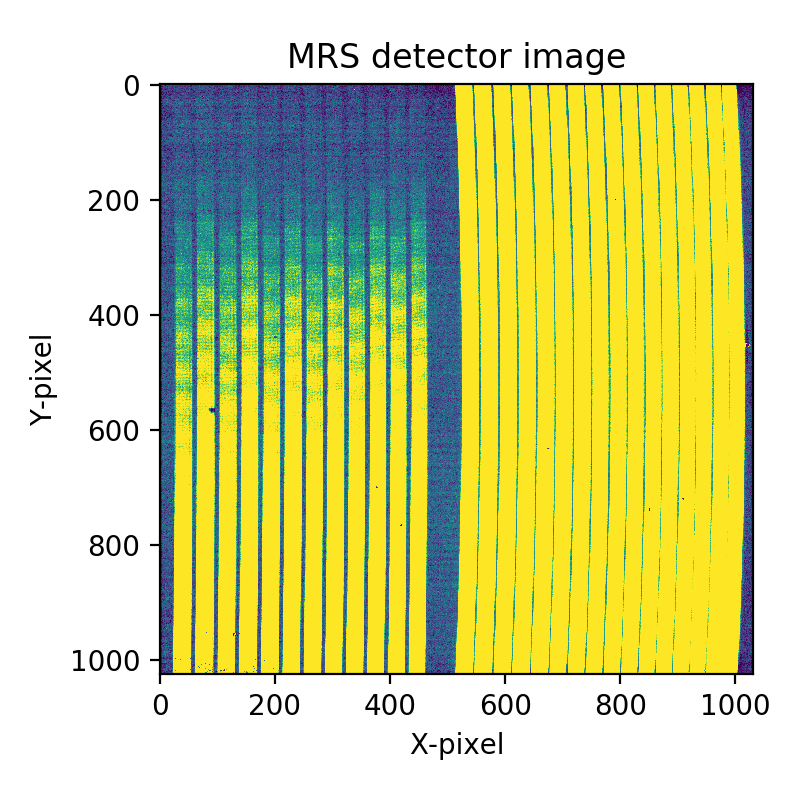

<IPython.core.display.Javascript object>


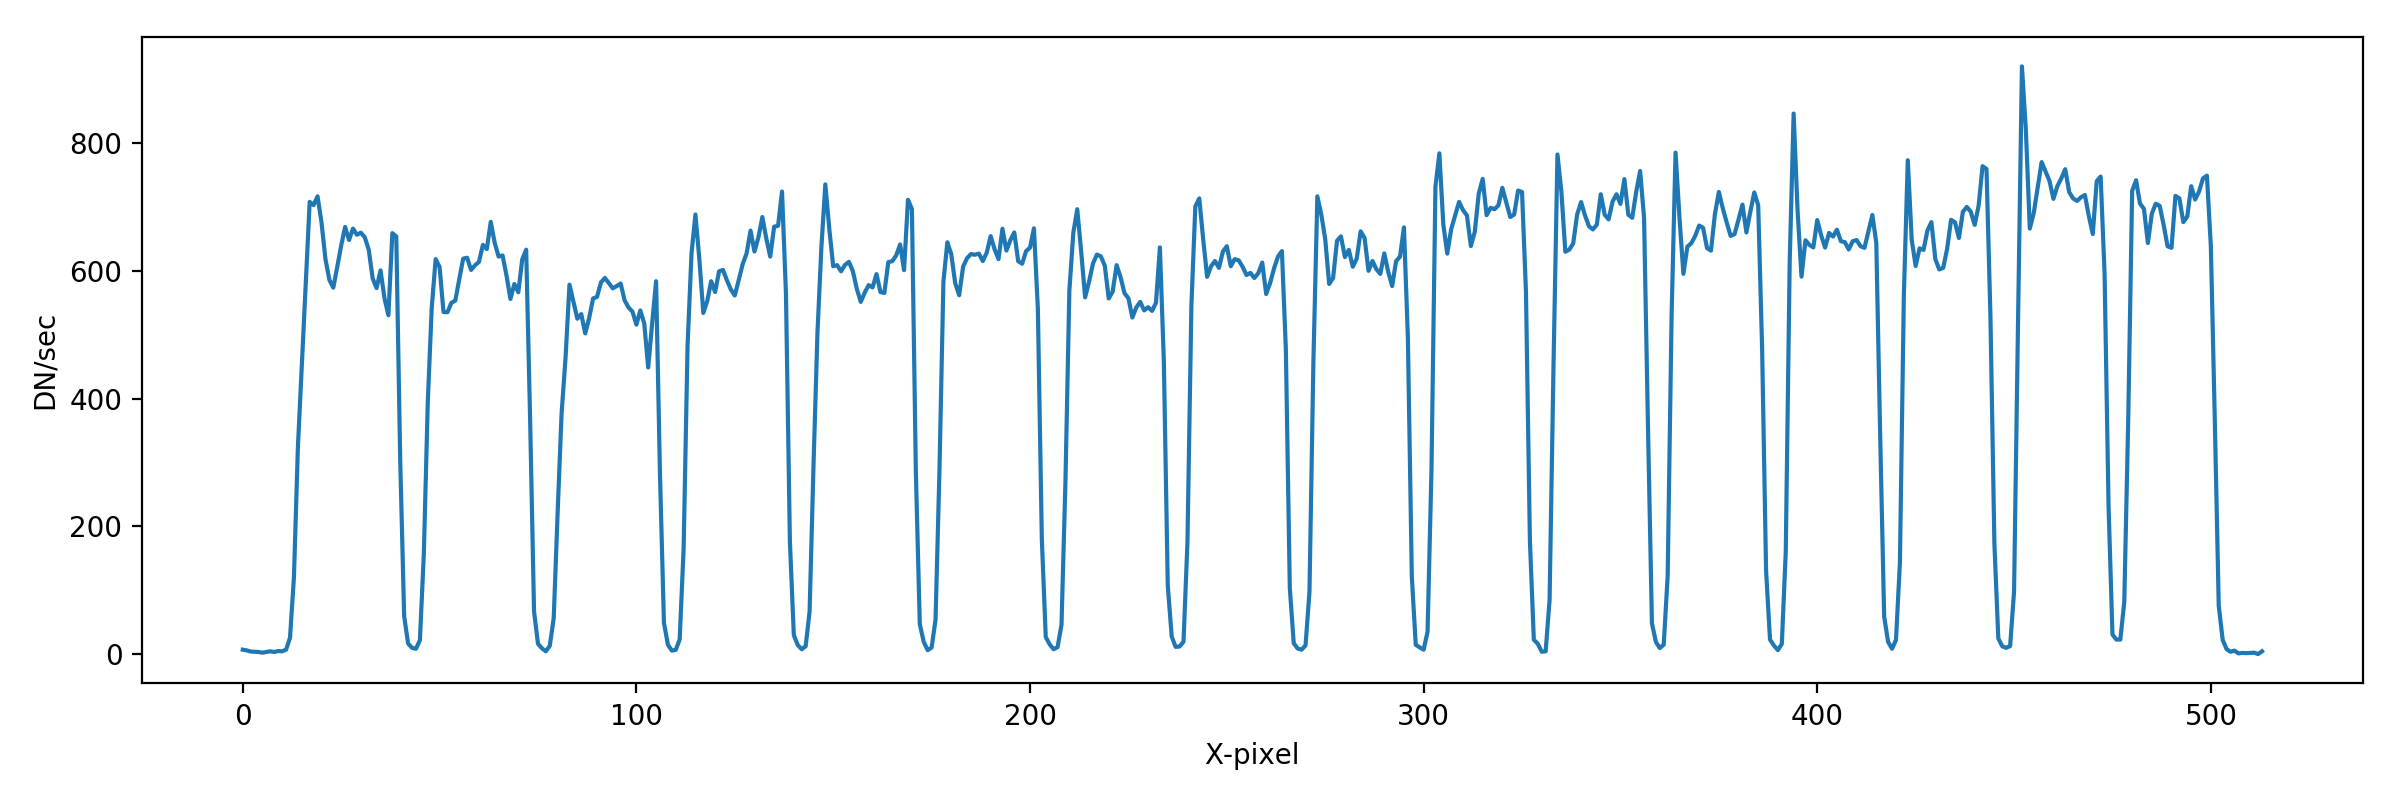

In [38]:
slope_img = (image_data[3,:,:]-image_data[2,:,:])/frame_delta_time
plt.figure(figsize=(4,4))
plt.imshow(slope_img,vmin=-5,vmax=20)
plt.xlabel('X-pixel')
plt.ylabel('Y-pixel')
plt.title('MRS detector image')
plt.tight_layout()

row = 512
plt.figure(figsize=(12,4))
if band[0] in ['1','4']:
    plt.plot(slope_img[row,10:512])
elif band[0] in ['2','3']:
    plt.plot(slope_img[row,512:1026])
plt.xlabel('X-pixel')
plt.ylabel('DN/sec')
plt.tight_layout()

<IPython.core.display.Javascript object>


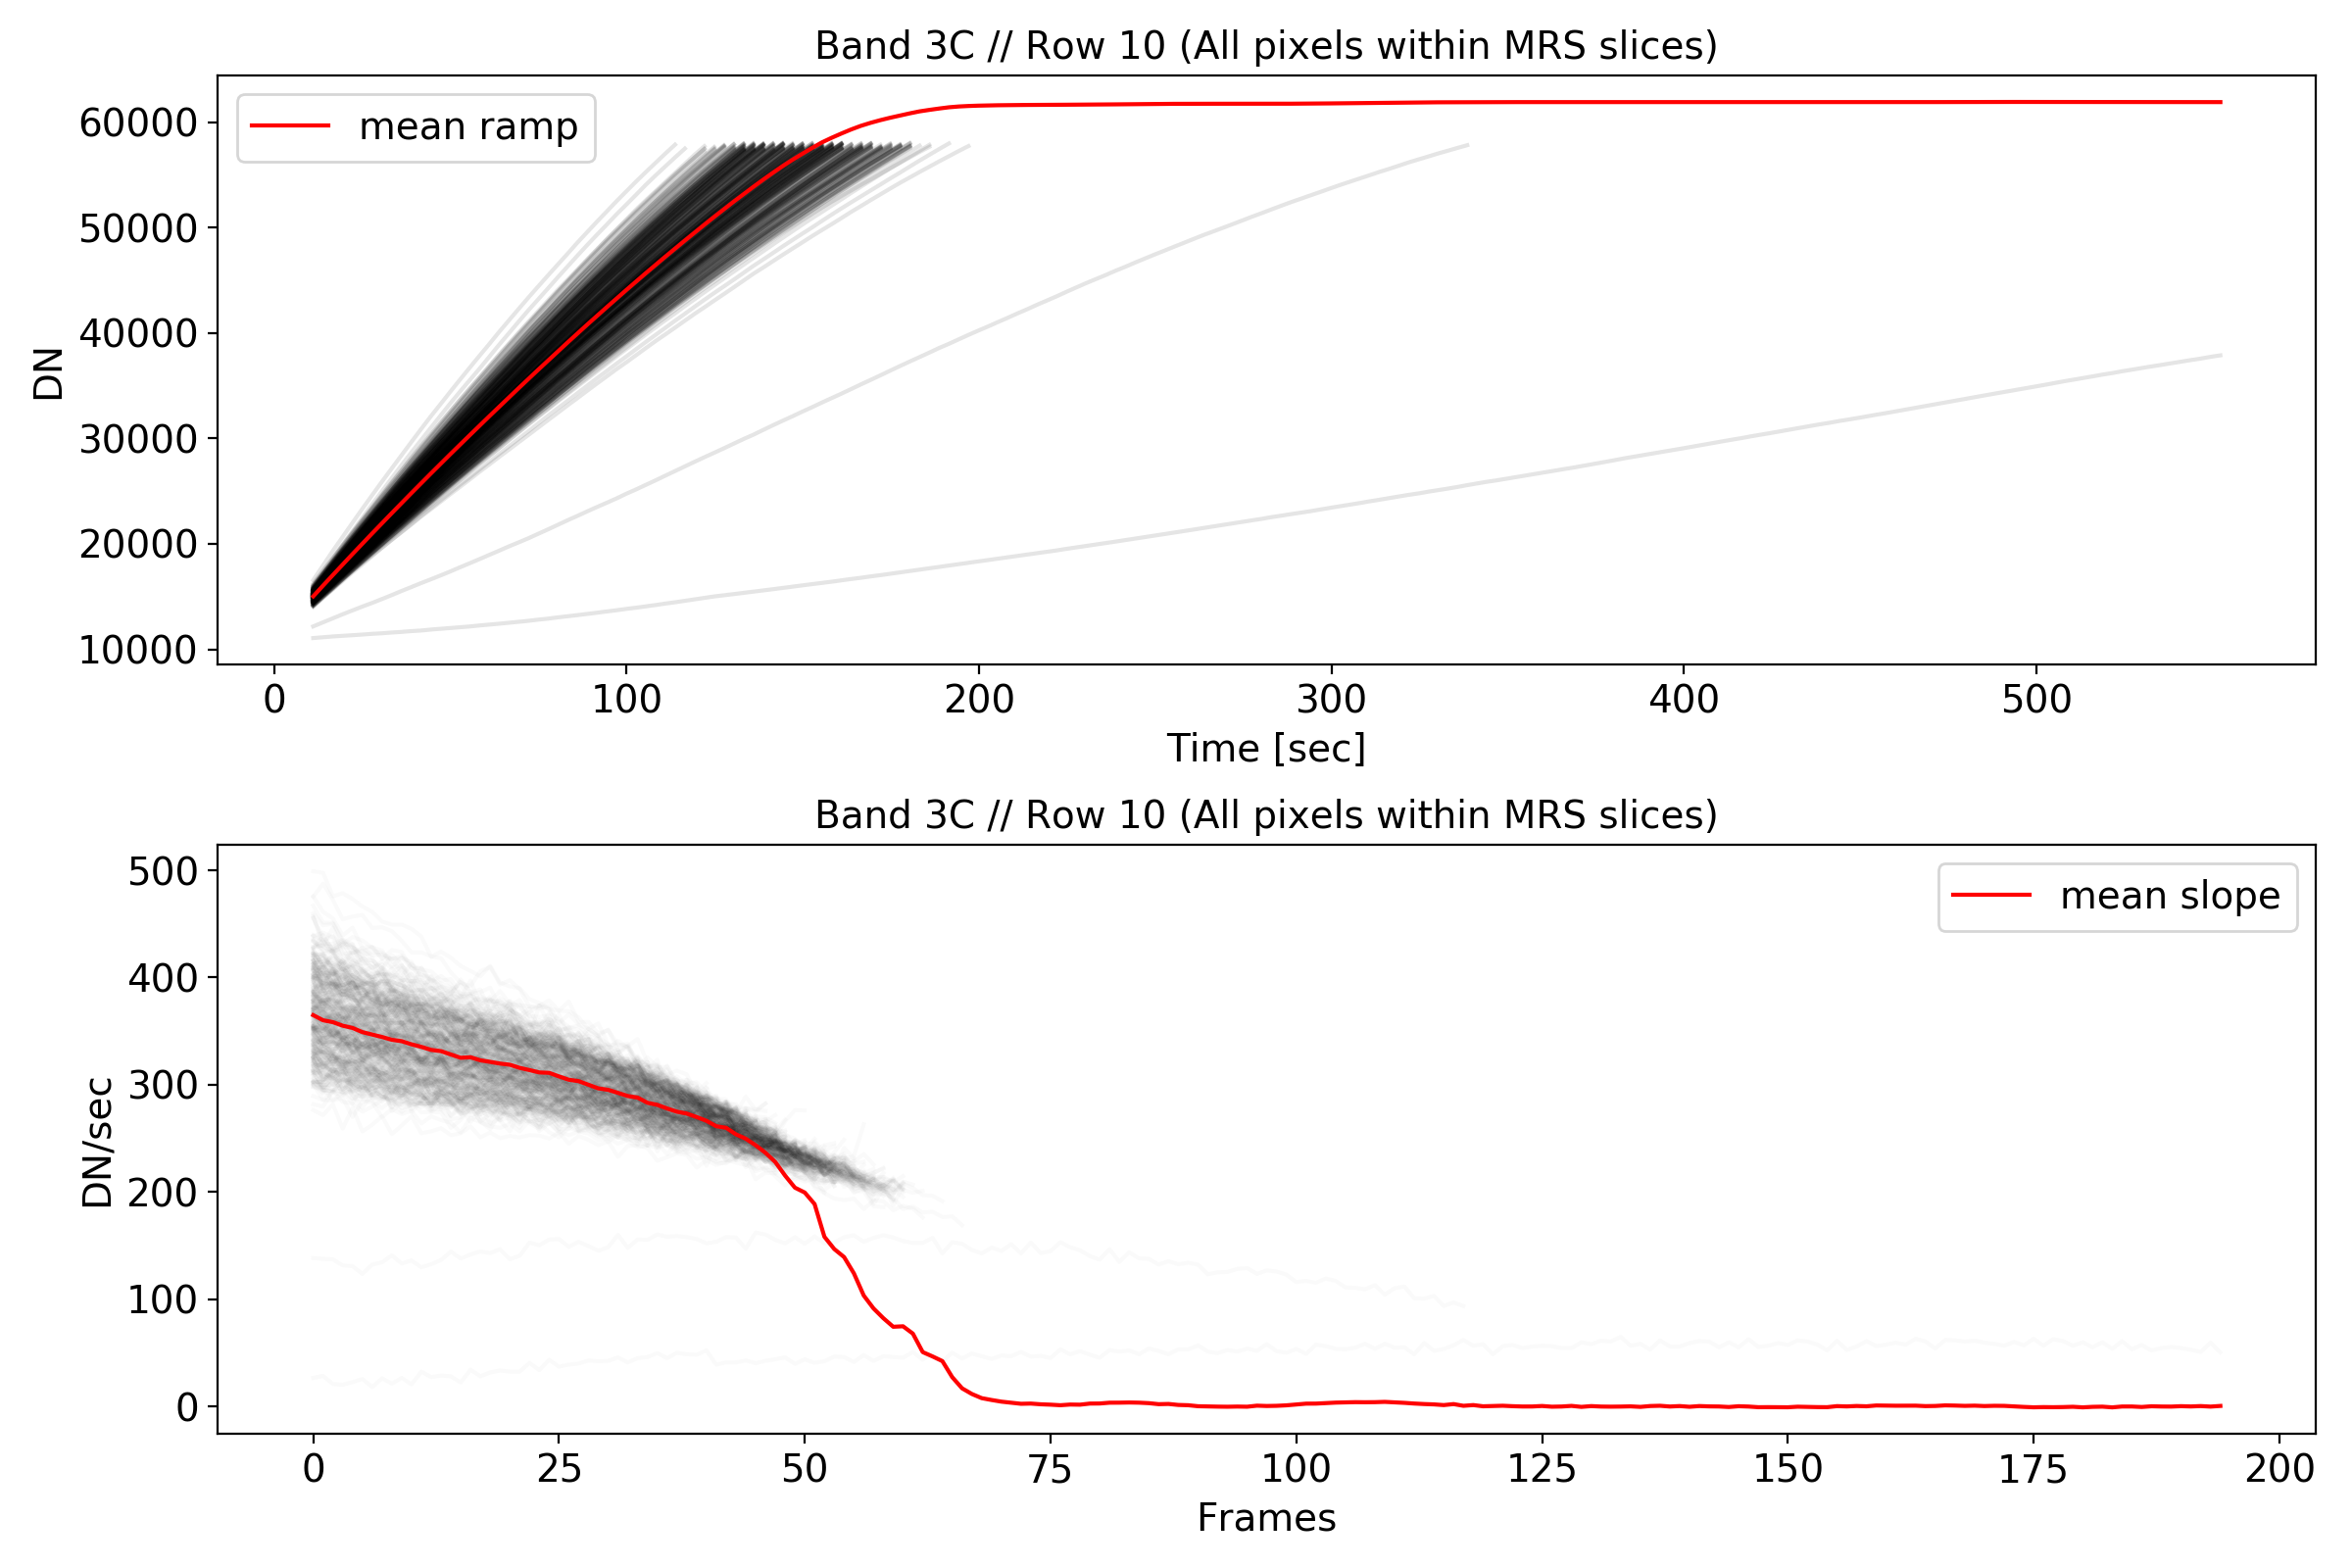

In [39]:
plt.close('all')

if band[0] in ['1','4']:
    range_x = range(10,512)
elif band[0] in ['2','3']:
    range_x = range(512,1020)

time  = np.arange(1,nframes+1)[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups]*frame_delta_time
reduced_time = time[skip_first:-skip_last]
ramp_arr,slope_arr = [],[]
d2cMaps   = funcs.load_obj('d2cMaps_band{}_tr90pc'.format(band),path=d2cMapDir)

fig,axs = plt.subplots(2,1,figsize=(12,8))
for ypos in [10]:
    for xpos in range_x:
        if d2cMaps['sliceMap'][ypos,xpos] != 0:
            tramp = image_data[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups,ypos,xpos]
            time2,tramp2 = time[skip_first:-skip_last],tramp[skip_first:-skip_last]
            time3,tramp3 = time2[tramp2 < 58000],tramp2[tramp2 < 58000]
            ramp_arr.append(tramp2)
            slope_arr.append(np.diff(tramp2)/frame_delta_time)
            axs[0].plot(time3,tramp3,'k',alpha=0.1)
            axs[1].plot(np.diff(tramp3)/frame_delta_time,'k',alpha=0.02)
ramp_arr = np.array(ramp_arr)
slope_arr = np.array(slope_arr)
axs[0].plot(time3,np.mean(ramp_arr,axis=0),'r',label='mean ramp')
axs[1].plot(np.mean(slope_arr,axis=0),'r',label='mean slope')
axs[0].set_xlabel('Time [sec]',fontsize=14)
axs[0].set_ylabel('DN',fontsize=14)
axs[1].set_xlabel('Frames',fontsize=14)
axs[1].set_ylabel('DN/sec',fontsize=14)
for plot in range(2):
    axs[plot].legend(fontsize=14)
    axs[plot].set_title('Band {} // Row {} (All pixels within MRS slices)'.format(band,ypos),fontsize=14)
    axs[plot].tick_params(axis='both',labelsize=14)
plt.tight_layout()

<IPython.core.display.Javascript object>


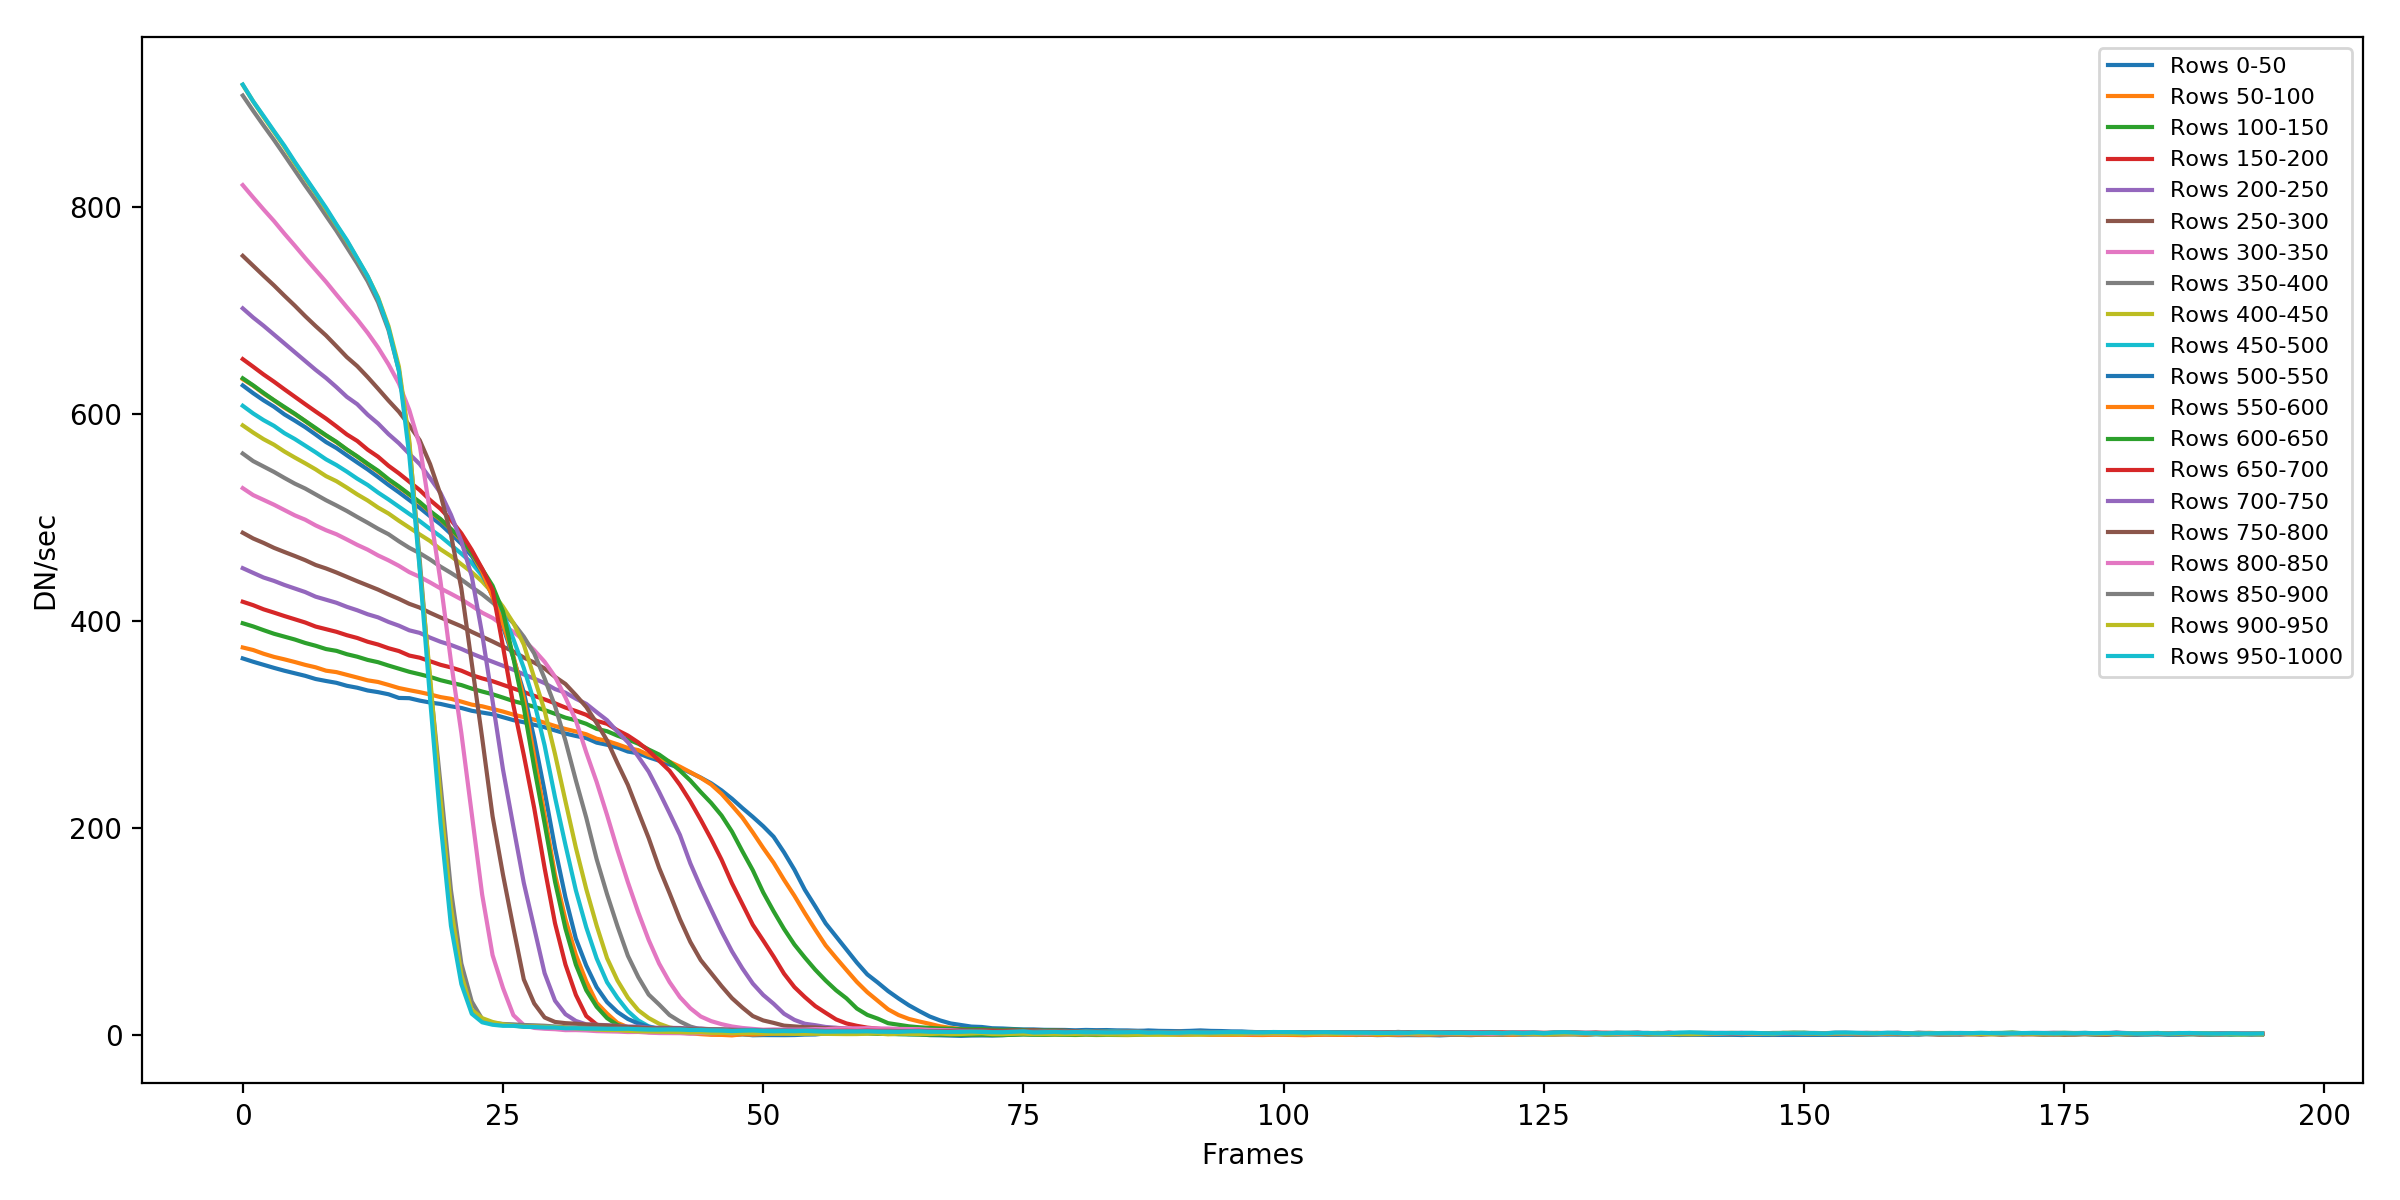

In [40]:
plt.close('all')

if band[0] in ['1','4']:
    range_x = range(10,512)
elif band[0] in ['2','3']:
    range_x = range(512,1020)

time  = np.arange(1,nframes+1)[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups]*frame_delta_time
reduced_time = time[skip_first:-skip_last]
d2cMaps   = funcs.load_obj('d2cMaps_band{}_tr90pc'.format(band),path=d2cMapDir)

step = 50
plt.figure(figsize=(12,6))
for i in range(1024/step):
    ramp_arr = []
    for ypos in range(i*step,(i+1)*step):
        for xpos in range_x:
            if d2cMaps['sliceMap'][ypos,xpos] != 0:
                tramp = image_data[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups,ypos,xpos]
                tramp[np.isnan(tramp)] = 0
                time2,tramp2 = time[skip_first:-skip_last],tramp[skip_first:-skip_last]
                time3,tramp3 = time2[tramp2 < 58000],tramp2[tramp2 < 58000]
                ramp_arr.append(tramp2)
    ramp_arr = np.array(ramp_arr)
    plt.plot(np.diff(np.mean(ramp_arr,axis=0))/frame_delta_time,label='Rows {}-{}'.format(i*step,(i+1)*step))
plt.xlabel('Frames')
plt.ylabel('DN/sec')
plt.legend(loc='upper right',fontsize=8)
plt.tight_layout()

In [11]:
# initialize placeholders
out_parameters = np.zeros(shape =(order + 1, image_shape[1], image_shape[2] ), dtype=np.float64)
count_rate_at_0DN = np.zeros(shape =(image_shape[1], image_shape[2] ), dtype=np.float64)

print('Output parameters (object shape): {}'.format(out_parameters.shape))
print('Count rate at 0DN (object shape): {}'.format(count_rate_at_0DN.shape))

Output parameters (object shape): (5, 1024, 1032)
Count rate at 0DN (object shape): (1024, 1032)


## Derive non-linearity correction for a single pixel

<IPython.core.display.Javascript object>


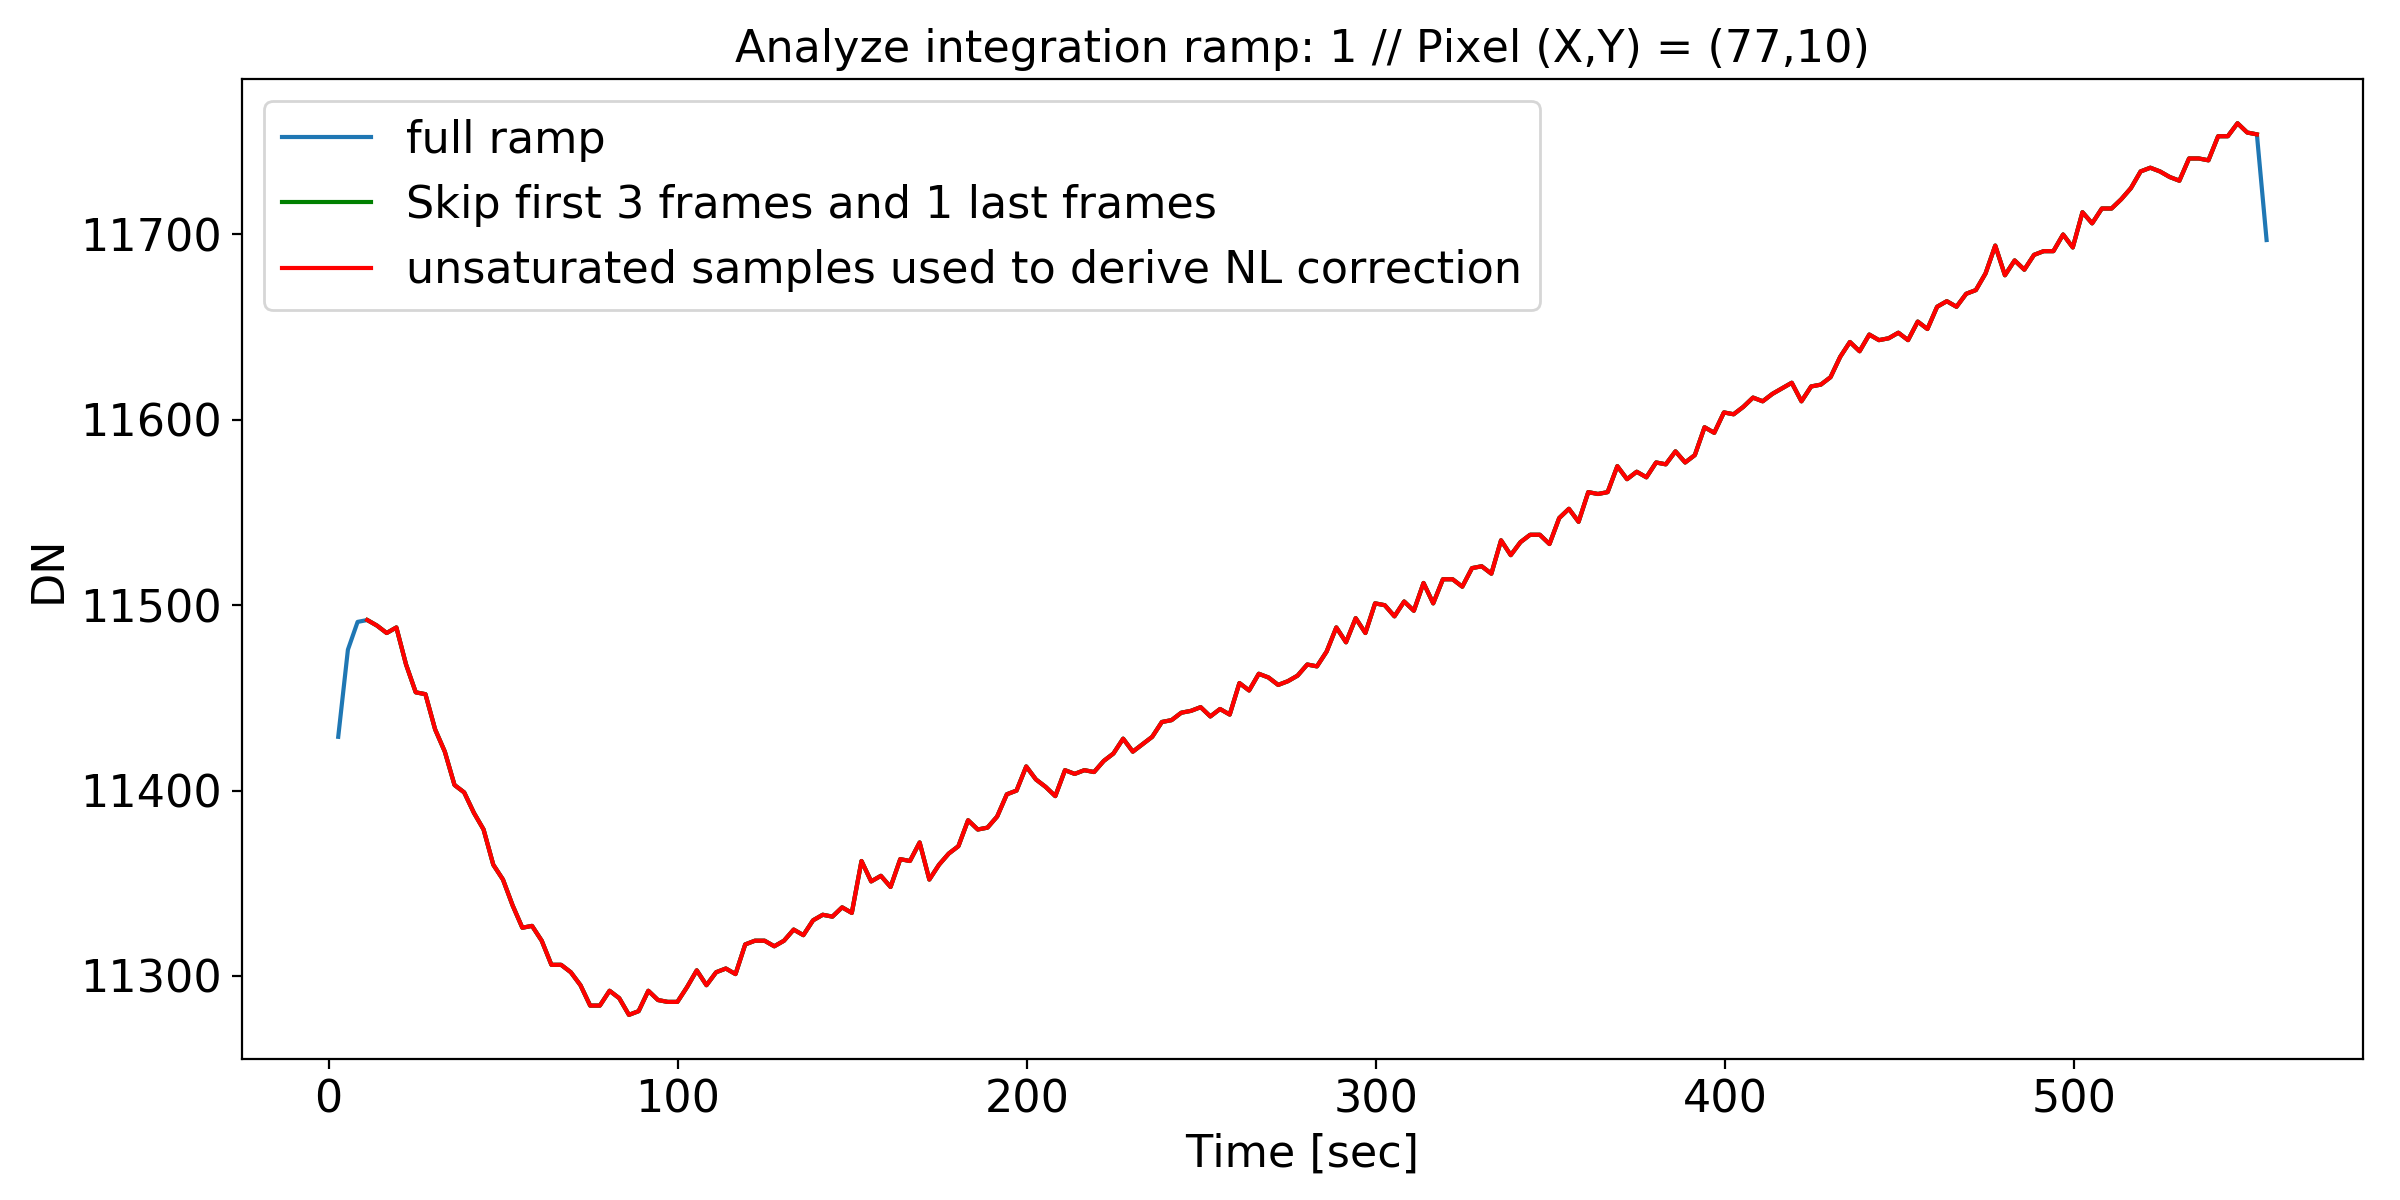

In [13]:
# Define ramp to be used for derivation of non-linearity correction
d2cMaps   = funcs.load_obj('d2cMaps_band{}_tr90pc'.format(band),path=d2cMapDir)
trace_y,trace_x = funcs.detpixel_trace(band,d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0.)

row = 10
ypos,xpos = trace_y[row],trace_x[row]

time  = np.arange(1,nframes+1)[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups]*frame_delta_time
tramp = image_data[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups,ypos,xpos]
time2,tramp2 = time[skip_first:-skip_last],tramp[skip_first:-skip_last]
time3,tramp3 = time2[tramp2 < 58000],tramp2[tramp2 < 58000]

plt.figure(figsize=(12,6))
plt.plot(time,tramp,label='full ramp')
plt.plot(time2,tramp2,'g',label='Skip first {} frames and {} last frames'.format(skip_first,skip_last))
plt.plot(time3,tramp3,'r',label='unsaturated samples used to derive NL correction')
plt.xlabel('Time [sec]',fontsize=16)
plt.ylabel('DN',fontsize=16)
plt.legend(fontsize=16)
plt.title('Analyze integration ramp: {} // Pixel (X,Y) = ({},{})'.format(analyze_ramp,xpos,ypos),fontsize=16)
plt.tick_params(axis='both',labelsize=16)
plt.tight_layout()

<IPython.core.display.Javascript object>


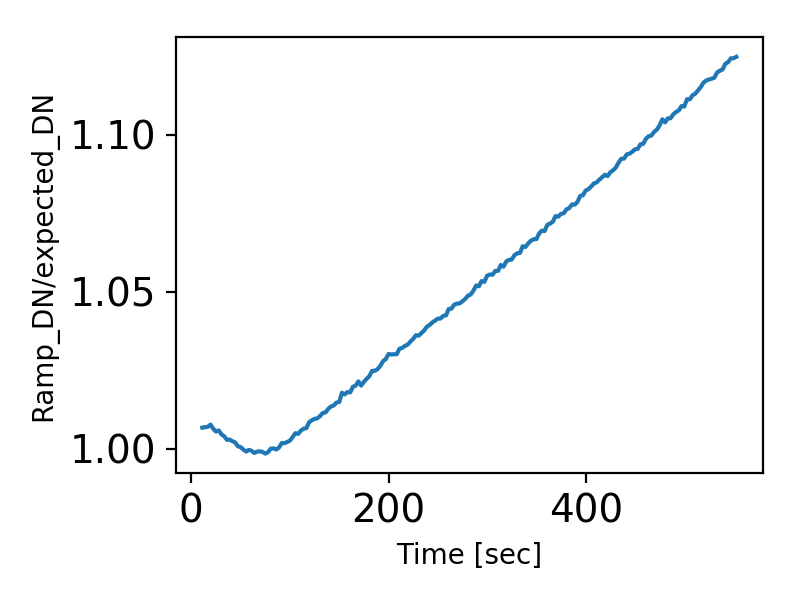

<IPython.core.display.Javascript object>


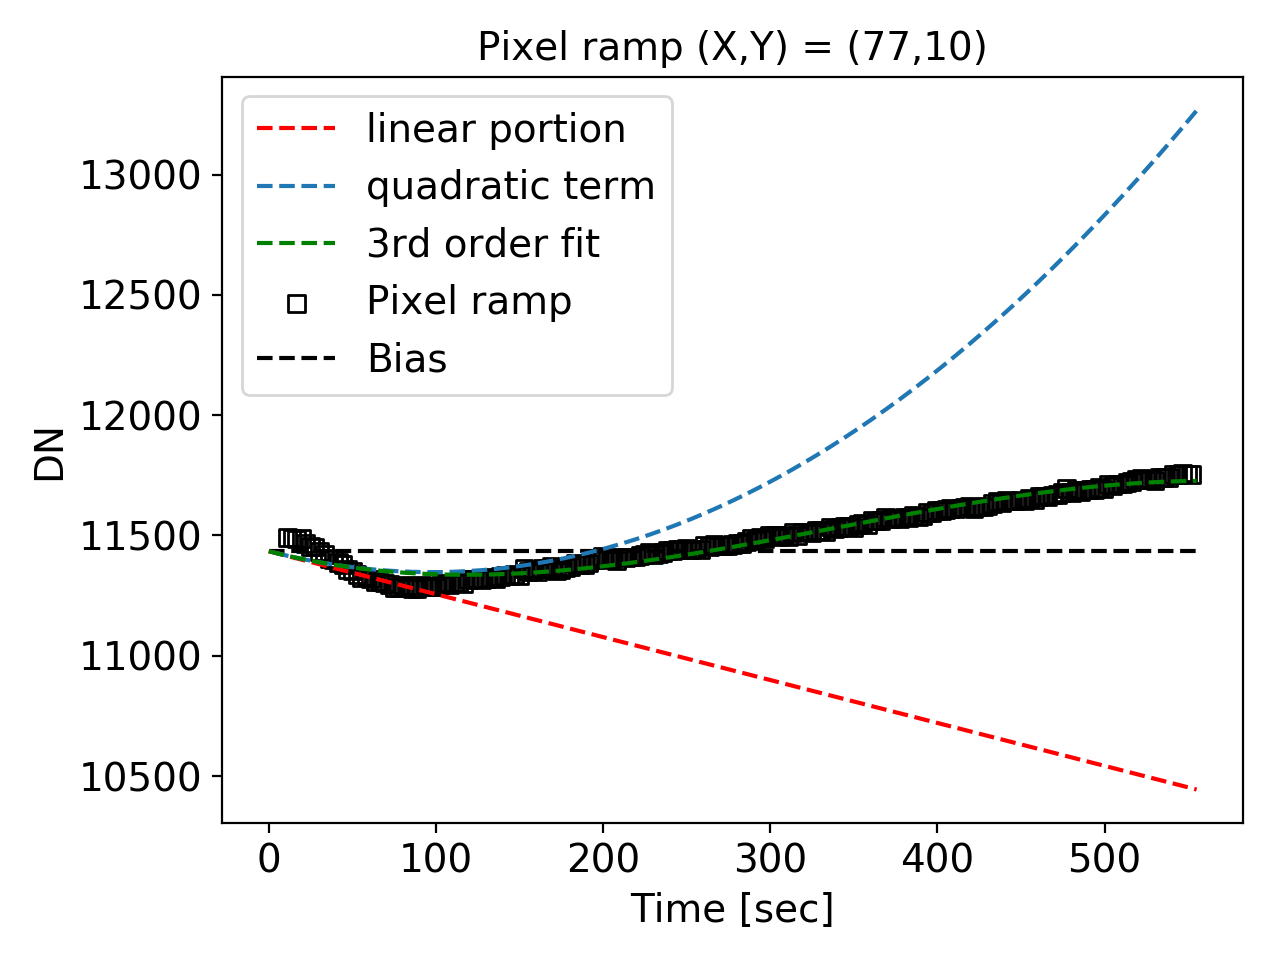

<IPython.core.display.Javascript object>


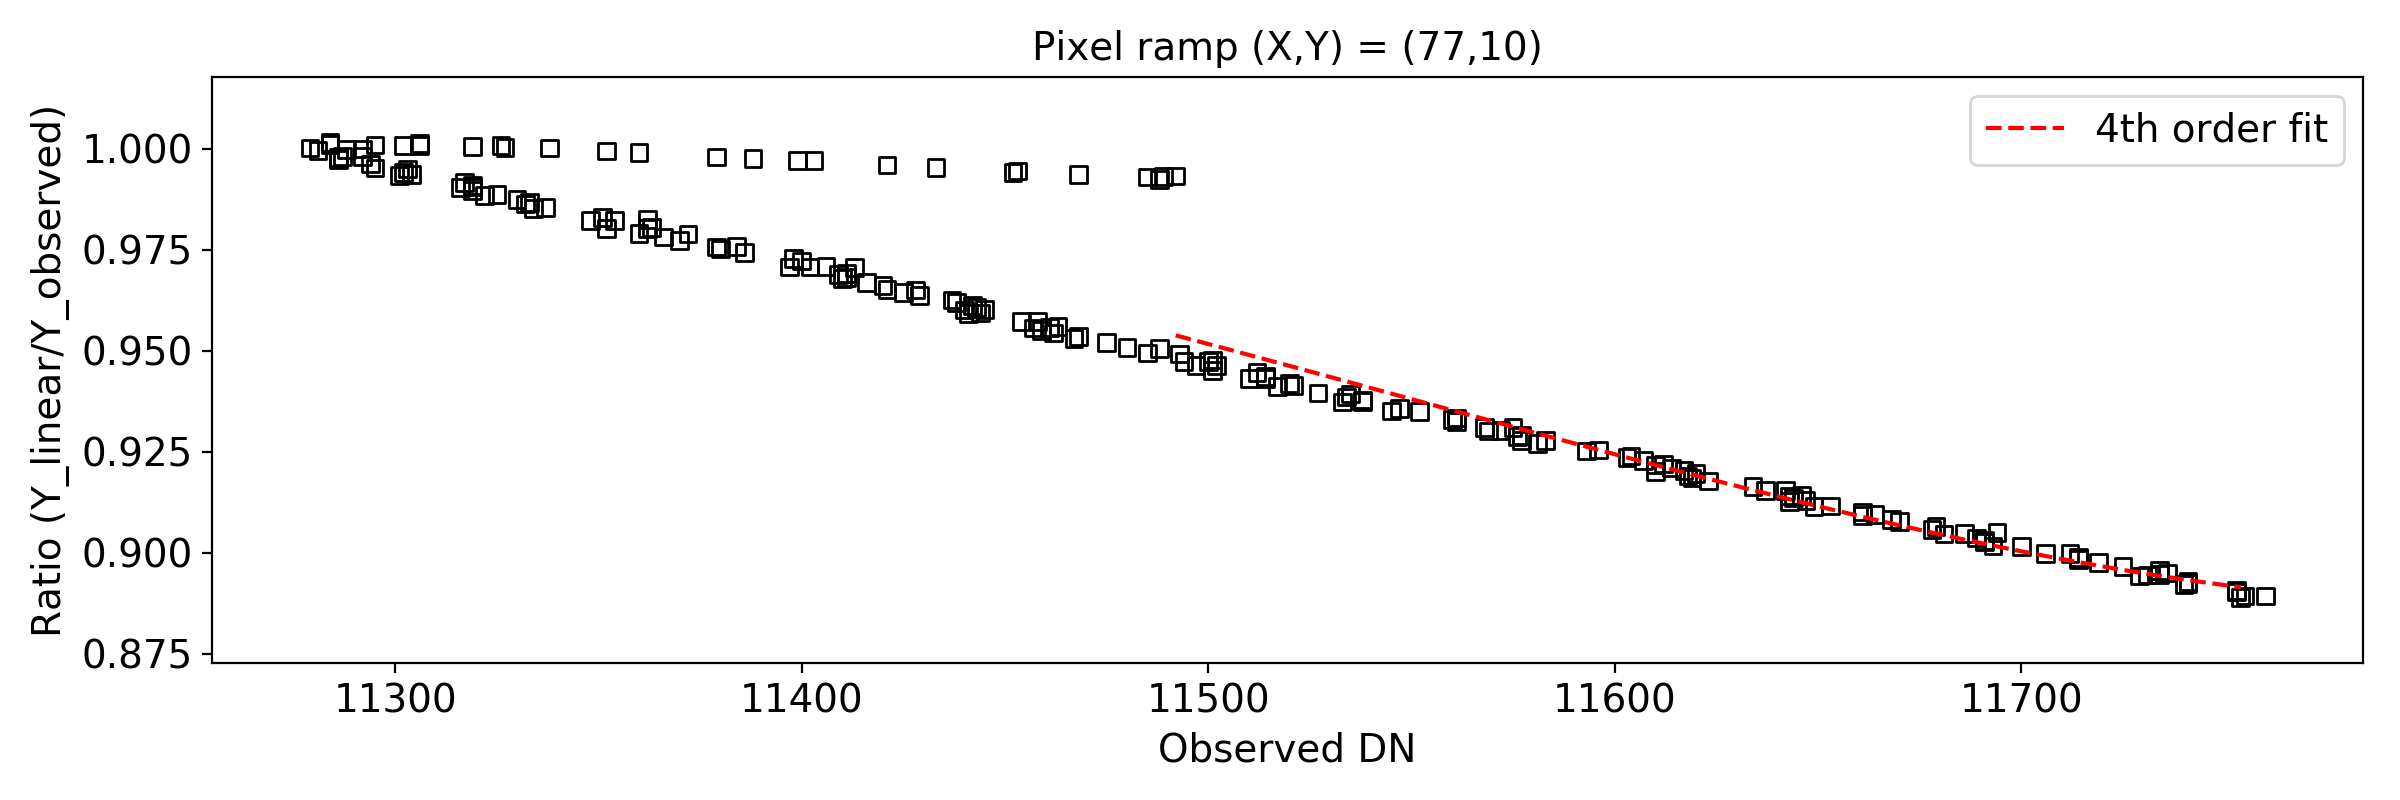

In [14]:
# derive non-linearity correction
intime = time3
inramp = tramp3

num_samples = inramp.size
first_fit_order = 3
assert num_samples > order + 3, 'Not enough samples to derive a non-linearity correction'

if first_fit_order == 2:
    bias,linear_term,quad_term = np.polynomial.polynomial.polyfit(intime, inramp, first_fit_order)
elif first_fit_order == 3:
    bias,linear_term,quad_term,cubic_term = np.polynomial.polynomial.polyfit(intime, inramp, first_fit_order)
elif first_fit_order == 4:
    bias,linear_term,quad_term,cubic_term,fourth_order_term = np.polynomial.polynomial.polyfit(intime, inramp, first_fit_order)

expected_rate = linear_term
expected_DN = bias+linear_term*intime

plt.figure(figsize=(4,3))
plt.plot(intime,inramp/expected_DN)
plt.xlabel('Time [sec]')
plt.ylabel('Ramp_DN/expected_DN')
plt.tick_params(axis='both',labelsize=14)
plt.tight_layout()

time_array = np.arange(skip_first+len(inramp)+skip_last+1)*frame_delta_time
plt.figure()
plt.scatter(intime,inramp,marker='s',facecolors='none',edgecolors='k',label='Pixel ramp')
# plt.plot(intime,expected_rate * (intime-intime[0]) + inramp[0],label='Expected DN as defined by Mike Regan')
plt.hlines(bias,0,time[-1],'k',linestyle='dashed',label='Bias')
plt.plot(time_array,bias+linear_term*time_array,'r',label='linear portion',linestyle='dashed')
plt.plot(time,bias+linear_term*time+quad_term*time**2,label='quadratic term',linestyle='dashed')
if first_fit_order == 3:
    plt.plot(time_array,bias+linear_term*time_array+quad_term*time_array**2+cubic_term*time_array**3,'g',label='3rd order fit',linestyle='dashed')
elif first_fit_order == 4:
    plt.plot(time_array,bias+linear_term*time_array+quad_term*time_array**2+cubic_term*time_array**3+fourth_order_term*time_array**4,'g',label='4th order fit',linestyle='dashed')
plt.xlabel('Time [sec]',fontsize=14)
plt.ylabel('DN',fontsize=14)
plt.legend(fontsize=14)
plt.title('Pixel ramp (X,Y) = ({},{})'.format(xpos,ypos),fontsize=14)
plt.tick_params(axis='both',labelsize=14)
plt.tight_layout()

# now get the ratio between the expected DN and the actual DN. 
# This is the correction factor.
correction_factor = expected_DN/inramp
assert np.sum(np.isfinite(correction_factor)) == correction_factor.size, 'There are non legal values in the correction factor array'

#solve for the correction factor as a function of observed DN.
coefs = np.polynomial.polynomial.polyfit(inramp, correction_factor, order)
poly = np.poly1d(coefs[::-1])

ramp = np.linspace(inramp[0],inramp[-1],1000)
plt.figure(figsize=(12,4))
# plt.plot(ramp,poly(ramp))
plt.scatter(inramp,correction_factor,marker='s',facecolors='none',edgecolors='k')
# plt.hlines(coefs[0],0,inramp[-1],'k',linestyle='dashed',label='Bias')
plt.plot(ramp,coefs[0]+coefs[1]*ramp+coefs[2]*ramp**2+coefs[3]*ramp**3+coefs[4]*ramp**4,'r',label='4th order fit',linestyle='dashed')
plt.xlabel('Observed DN',fontsize=14)
plt.ylabel('Ratio (Y_linear/Y_observed)',fontsize=14)
plt.legend(fontsize=14)
plt.title('Pixel ramp (X,Y) = ({},{})'.format(xpos,ypos),fontsize=14)
plt.tick_params(axis='both',labelsize=14)
plt.tight_layout()

In [15]:
# insert results in placeholder array
out_parameters[:, ypos,xpos] = coefs
count_rate_at_0DN[ypos,xpos] = expected_rate

In [16]:
# apply correction
# define placeholders
out_ramp = np.zeros_like(inramp, dtype=np.float64)
new_rate = np.zeros(shape=(len(inramp)-1, image_shape[1], image_shape[2]), dtype=np.float64)

print('Output ramp (object shape): {}'.format(out_ramp.shape))
print('New rate (object shape): {}'.format(new_rate.shape))

Output ramp (object shape): (196,)
New rate (object shape): (195, 1024, 1032)


<IPython.core.display.Javascript object>


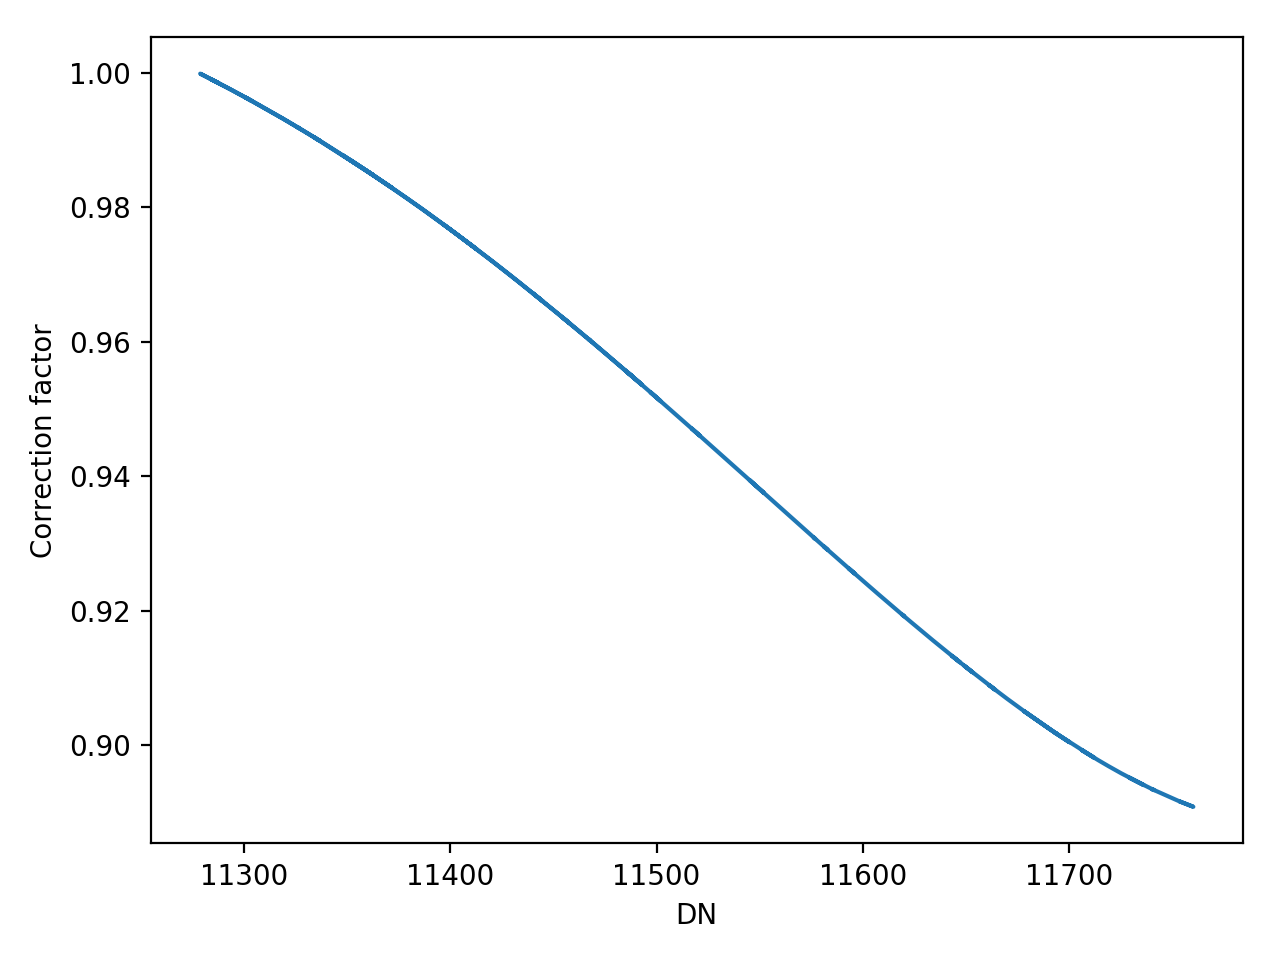

<IPython.core.display.Javascript object>


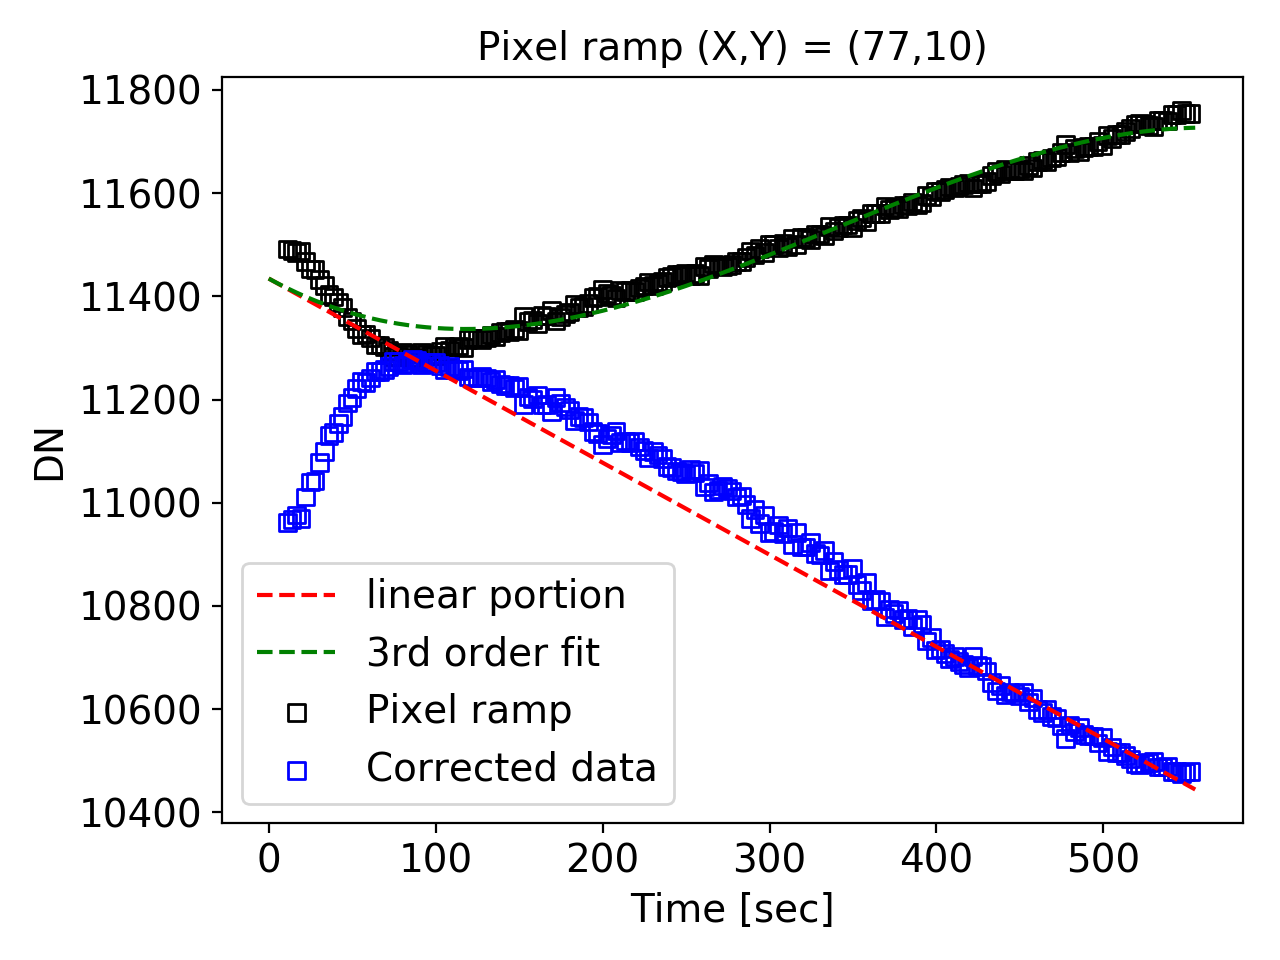

<IPython.core.display.Javascript object>


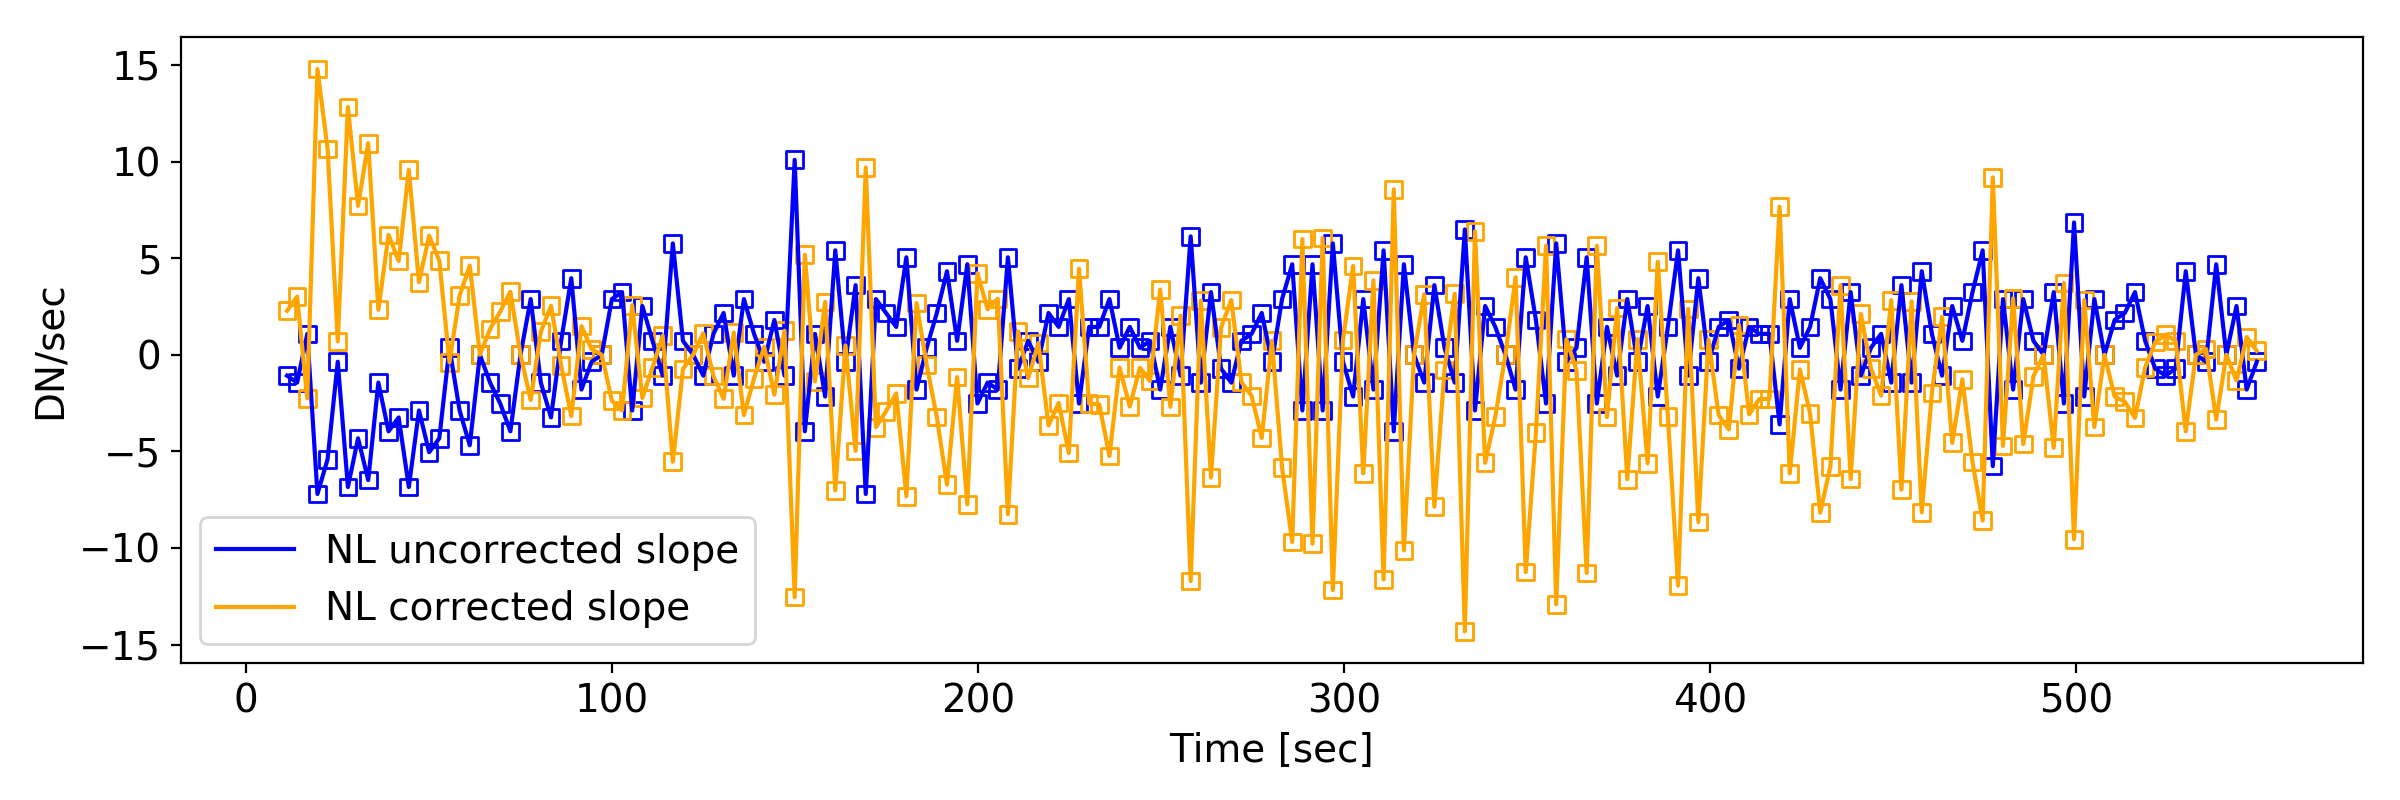

In [17]:
cor_factor = np.polynomial.polynomial.polyval(inramp, out_parameters[:, ypos, xpos])

plt.figure()
plt.plot(inramp,cor_factor)
plt.xlabel('DN')
plt.ylabel('Correction factor')
plt.tight_layout()

# correct ramp by applying derived NL correction
corrected_ramp = cor_factor * inramp

time_array = np.arange(skip_first+len(inramp)+skip_last+1)*frame_delta_time
plt.figure()
plt.scatter(intime,inramp,marker='s',facecolors='none',edgecolors='k',label='Pixel ramp')
plt.scatter(intime,corrected_ramp,marker='s',facecolors='none',edgecolors='b',label='Corrected data')
plt.plot(time_array,bias+linear_term*time_array,'r',label='linear portion',linestyle='dashed')
if first_fit_order == 3:
    plt.plot(time_array,bias+linear_term*time_array+quad_term*time_array**2+cubic_term*time_array**3,'g',label='3rd order fit',linestyle='dashed')
elif first_fit_order == 4:
    plt.plot(time_array,bias+linear_term*time_array+quad_term*time_array**2+cubic_term*time_array**3+fourth_order_term*time_array**4,'g',label='4th order fit',linestyle='dashed')
plt.xlabel('Time [sec]',fontsize=14)
plt.ylabel('DN',fontsize=14)
plt.legend(fontsize=14)
plt.title('Pixel ramp (X,Y) = ({},{})'.format(xpos,ypos),fontsize=14)
plt.tick_params(axis='both',labelsize=14)
plt.tight_layout()

new_rate_DN = np.diff(corrected_ramp)
new_rate[:, ypos, xpos] = new_rate_DN

plt.figure(figsize=(12,4))
plt.scatter(intime[:-1],np.diff(inramp)/frame_delta_time,marker='s',facecolors='none',edgecolors='b')
plt.plot(intime[:-1],np.diff(inramp)/frame_delta_time,'b',label='NL uncorrected slope')
plt.scatter(intime[:-1],new_rate_DN/frame_delta_time,marker='s',facecolors='none',edgecolors='orange')
plt.plot(intime[:-1],new_rate_DN/frame_delta_time,'orange',label='NL corrected slope')
plt.xlabel('Time [sec]',fontsize=14)
plt.ylabel('DN/sec',fontsize=14)
plt.legend(fontsize=14)
plt.tick_params(axis='both',labelsize=14)
plt.tight_layout()

### Compute depth of dip below frame 30 for all pixels

<IPython.core.display.Javascript object>


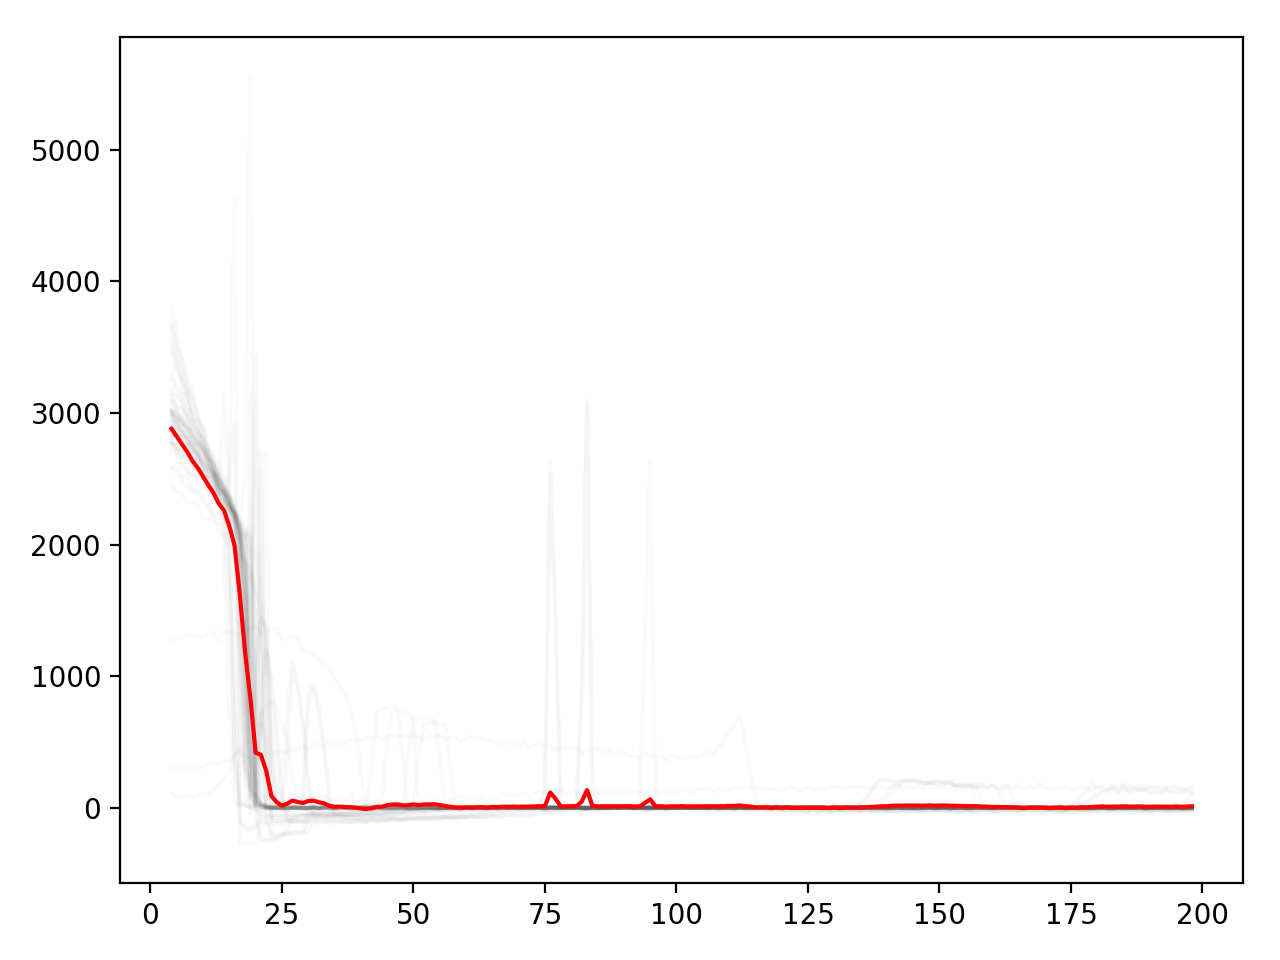

In [41]:
plt.close('all')

if band[0] in ['1','4']:
    range_x = range(10,512)
elif band[0] in ['2','3']:
    range_x = range(512,1020)

time  = np.arange(1,nframes+1)[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups]*frame_delta_time
reduced_time = time[skip_first:-skip_last]
ramp_arr,slope_arr = [],[]
d2cMaps   = funcs.load_obj('d2cMaps_band{}_tr90pc'.format(band),path=d2cMapDir)
specres_table = funcs.get_cdps(band,cdpDir)[4]
oversampling = 2
lambcens,lambfwhms = funcs.spectral_gridding(band,d2cMaps,specres_table=specres_table,oversampling = oversampling)

ibin = 10 # len(lambcens)-10
coords = np.where((np.abs(d2cMaps['lambdaMap']-lambcens[ibin])<=lambfwhms[ibin]/2./oversampling))

tramp = np.transpose(image_data[(analyze_ramp-1)*ngroups+skip_first:analyze_ramp*ngroups-skip_last,coords[0],coords[1]])

slope = []
plt.figure()
for i in range(tramp.shape[0]):
    
    plt.plot(1+skip_first+np.arange(len(tramp[i,:]))[:-1],np.diff(tramp[i,:]),'k',alpha=0.02)
    slope.append(np.diff(tramp[i,:]))
slope = np.array(slope)
plt.plot(1+skip_first+np.arange(len(tramp[i,:]))[:-1],np.mean(slope,axis=0),'r',label='mean slope')
plt.tight_layout()

<IPython.core.display.Javascript object>


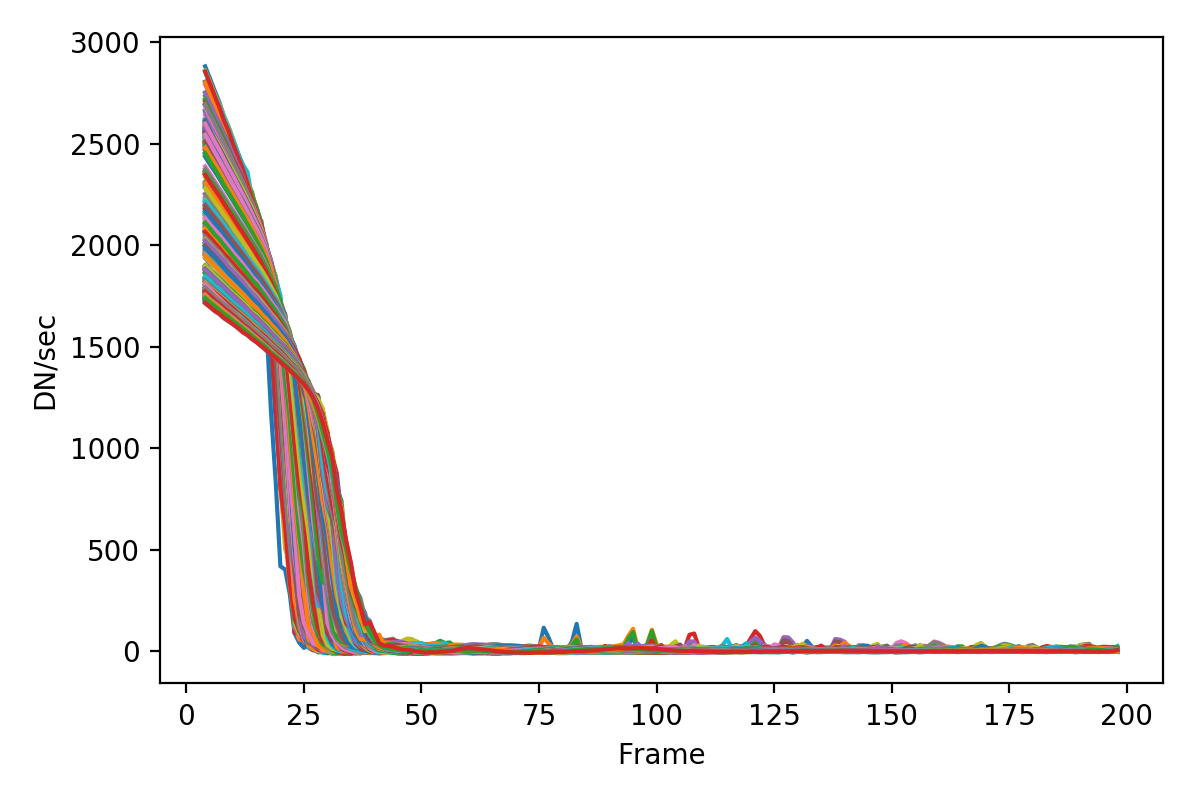

In [42]:
plt.close('all')
plt.figure(figsize=(6,4))
for ibin in range(10,len(lambcens[::2])-10):
    coords = np.where((np.abs(d2cMaps['lambdaMap']-lambcens[ibin])<=lambfwhms[ibin]/2./oversampling))
    tramp = np.transpose(image_data[(analyze_ramp-1)*ngroups+skip_first:analyze_ramp*ngroups-skip_last,coords[0],coords[1]])
    slope = []

    for i in range(tramp.shape[0]):
        slope.append(np.diff(tramp[i,:]))
    slope = np.array(slope)
    plt.plot(1+skip_first+np.arange(len(tramp[i,:]))[:-1],np.mean(slope,axis=0),label=np.round(lambcens[ibin]))
plt.xlabel('Frame')
plt.ylabel('DN/sec')
plt.tight_layout()

<IPython.core.display.Javascript object>


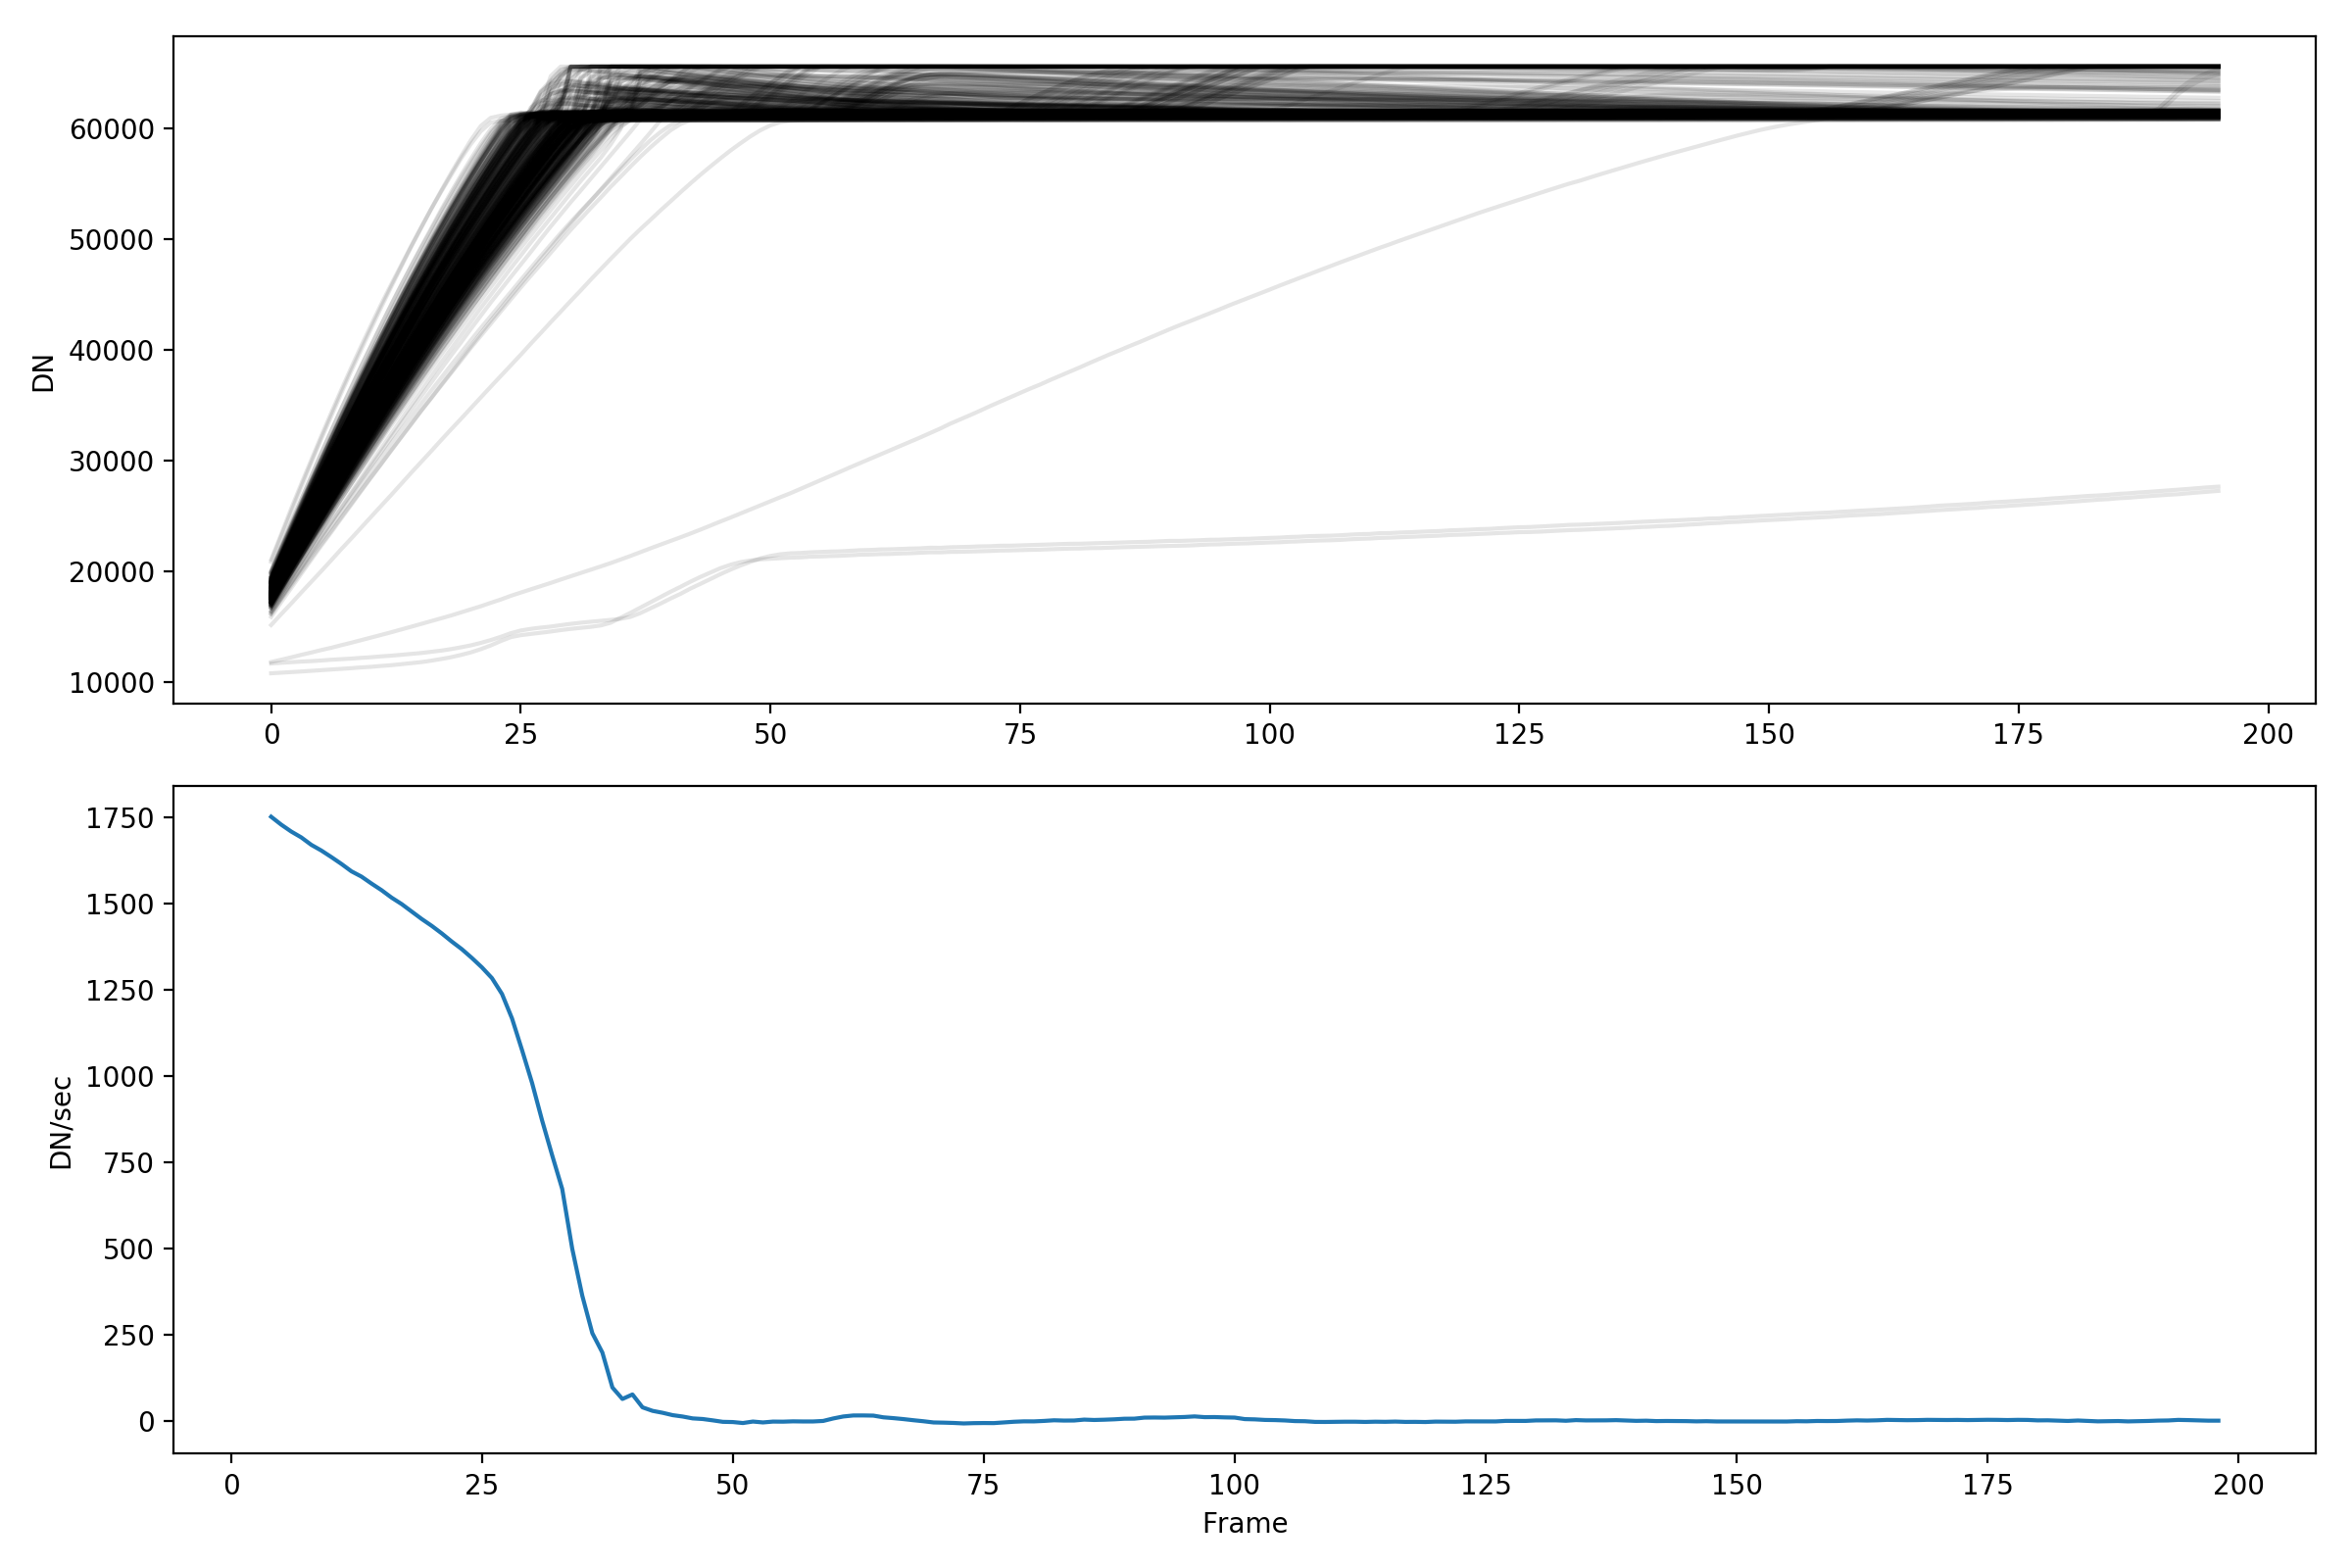

In [43]:
plt.close('all')
fig,axs = plt.subplots(2,1,figsize=(12,8))
for ibin in [len(lambcens[::2])-10]: # range(10,len(lambcens[::2])-10):
    coords = np.where((np.abs(d2cMaps['lambdaMap']-lambcens[ibin])<=lambfwhms[ibin]/2./oversampling))
    tramp = np.transpose(image_data[(analyze_ramp-1)*ngroups+skip_first:analyze_ramp*ngroups-skip_last,coords[0],coords[1]])
    slope = []
    tramp_len = []
    for i in range(tramp.shape[0]):
        if tramp[i,:][0]<30000:
            axs[0].plot(tramp[i,:],'k',alpha=0.1)
            slope.append(np.diff(tramp[i,:]))
            tramp_len.append(len(tramp[i,:][tramp[i,:]<58000]))
    slope,tramp_len = np.array(slope),np.array(tramp_len)
    min_len = min(tramp_len)
    frames = 1+skip_first+np.arange(len(tramp[i,:]))[:-1]
    
    axs[1].plot(frames,np.mean(slope,axis=0))
    if band == '4C':
        if min_len>60:
            bias,linear_term = np.polynomial.polynomial.polyfit(frames[50:min_len], np.mean(slope,axis=0)[50:min_len], 1)
            axs[1].vlines([50,min_len],(bias+linear_term*frames).min(),(bias+linear_term*frames).max(),'k')
            axs[1].plot(frames,bias+linear_term*frames)
    elif band == '4B':
        if min_len>40:
            bias,linear_term,quad_term = np.polynomial.polynomial.polyfit(frames[50:min_len], np.mean(slope,axis=0)[50:min_len], 2)
            axs[1].vlines([50,min_len],(bias+linear_term*frames).min(),(bias+linear_term*frames).max(),'k')
            axs[1].plot(frames,bias+linear_term*frames+quad_term*frames**2)
    elif band == '4A':
        if min_len>30:
            bias,linear_term = np.polynomial.polynomial.polyfit(frames[30:min_len], np.mean(slope,axis=0)[30:min_len], 1)
            axs[1].vlines([30,min_len],(bias+linear_term*frames).min(),(bias+linear_term*frames).max(),'k')
            axs[1].plot(frames,bias+linear_term*frames)
axs[1].set_xlabel('Frame')
axs[0].set_ylabel('DN')
axs[1].set_ylabel('DN/sec')
plt.tight_layout()

<IPython.core.display.Javascript object>


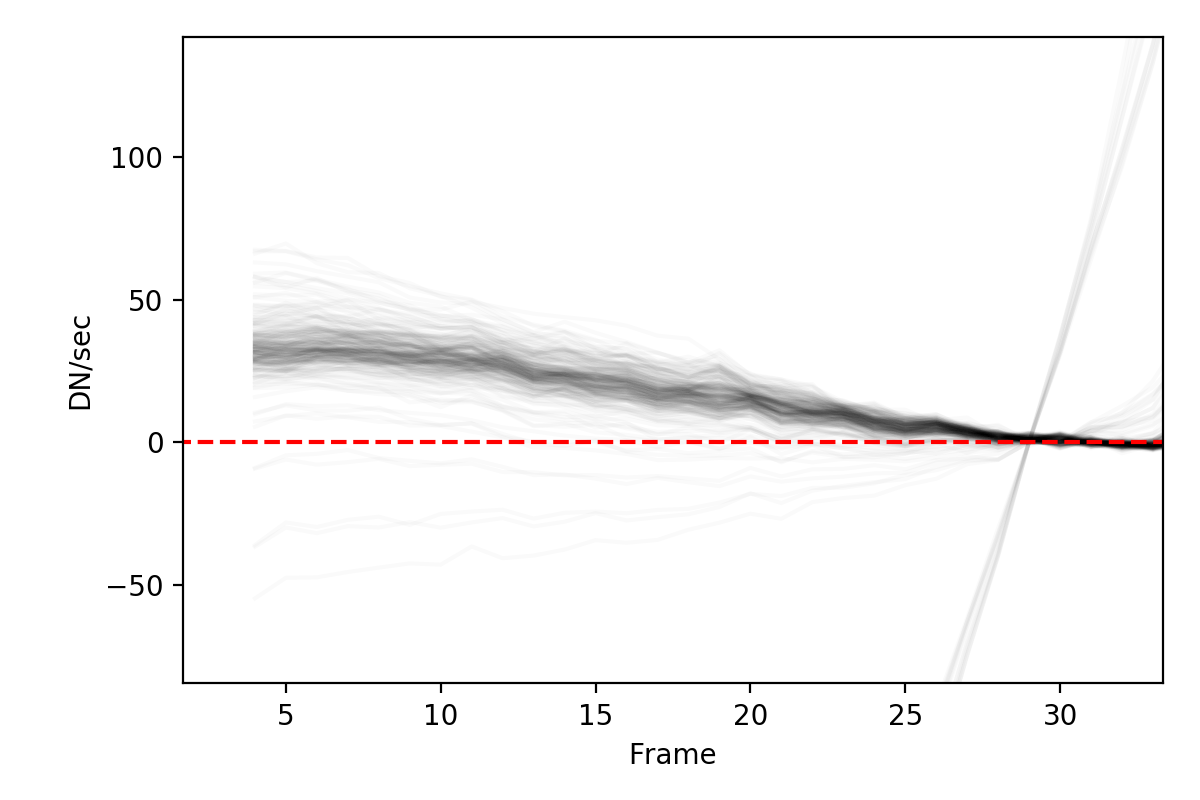

/Users/ioannisa/anaconda2/envs/miricle.20170307/lib/python2.7/site-packages/ipykernel/__main__.py:31: RankWarning: The fit may be poorly conditioned


In [45]:
plt.close('all')
plt.figure(figsize=(6,4))
for ibin in range(10,len(lambcens)-11):
    coords = np.where((np.abs(d2cMaps['lambdaMap']-lambcens[ibin])<=lambfwhms[ibin]/2./oversampling))
    tramp = np.transpose(image_data[(analyze_ramp-1)*ngroups+skip_first:analyze_ramp*ngroups-skip_last,coords[0],coords[1]])
    slope = []
    tramp_len = []

    for i in range(tramp.shape[0]):
        if tramp[i,:][0]<30000:
            slope.append(np.diff(tramp[i,:]))
            tramp_len.append(len(tramp[i,:][tramp[i,:]<58000]))
    slope,tramp_len = np.array(slope),np.array(tramp_len)
    min_len = min(tramp_len)
    frames = 1+skip_first+np.arange(len(tramp[i,:]))[:-1]
    
    if band == '4C':
        if min_len>60:
            bias,linear_term = np.polynomial.polynomial.polyfit(frames[60:min_len], np.mean(slope,axis=0)[60:min_len], 1)
            plt.plot(frames,(bias+linear_term*frames)-np.mean(slope,axis=0),'k',alpha=0.02,zorder=0)
    elif band == '4B':
        if min_len>40:
            bias,linear_term,quad_term = np.polynomial.polynomial.polyfit(frames[40:min_len], np.mean(slope,axis=0)[40:min_len], 2)
            plt.plot(frames,(bias+linear_term*frames+quad_term*frames**2)-np.mean(slope,axis=0),'k',alpha=0.02,zorder=0)
    elif band == '4A':
        if min_len>35:
            bias,linear_term = np.polynomial.polynomial.polyfit(frames[35:min_len], np.mean(slope,axis=0)[35:min_len], 1)
            plt.plot(frames,(bias+linear_term*frames)-np.mean(slope,axis=0),'k',alpha=0.02,zorder=0)
    elif band == '3C':
        if min_len>25:
            bias,linear_term = np.polynomial.polynomial.polyfit(frames[25:min_len], np.mean(slope,axis=0)[25:min_len], 1)
            plt.plot(frames,(bias+linear_term*frames)-np.mean(slope,axis=0),'k',alpha=0.02,zorder=0)
plt.hlines(0,0,ngroups,'r',linestyle='dashed',zorder=1)
plt.xlabel('Frame')
plt.ylabel('DN/sec')
plt.tight_layout()